In [163]:
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import decomposition
from scipy import spatial

In [130]:
db_file = './journal-database/database100_preprocessed.xlsx'
model = Word2Vec.load("trained_model.model")

In [131]:
topics = {
  "mk": "musculoskeletal radiology",
  "ct": "computed tomography",
  "br": "breast imaging",
  "gu": "geritourinary radiology",
  "us": "ultrasound",
  "ch": "chest radiology",
  "ir": "interventional radiology",
}

#test abstract
t_abstract = 'dual energy generally better diagnostic performance interreader reproducibility identify loosening tibial femoral component painful total knee prosthesis compared single energy radiography'

In [132]:
abstracts_list = []
titles_list = []
topics_list = []
for topic in topics:
    topics_list.append(topics[topic])
    array_of_abstracts = np.array(pd.read_excel(db_file, sheet_name=topic).abstract)
    array_of_titles = np.array(pd.read_excel(db_file, sheet_name=topic).title)
    abstracts_list.append(array_of_abstracts)
    titles_list.append(array_of_titles)
#abstracts_list[0] = all 'mk' abstracts
#abstracts_list[1] = all 'ct' abstracts
# .
# .
# .
#abstracts_list[last] = all 'ir' abstracts

In [133]:
wv = model.wv
def construct_word_vector_for_text(text_string):
    tokens = text_string.split(" ")
    vectors = []
    for token in tokens:
        vector_for_single_word = wv[token]
        vectors.append(vector_for_single_word)
    return np.mean(vectors, axis=0)
    #return vector_for_text

In [134]:
def wv_for_abstracts(list_of_abstracts):
    arr = []
    for hundred_abstracts in list_of_abstracts:
        hundred_arr = []
        for abstract in hundred_abstracts:
            wv = construct_word_vector_for_text(abstract)
            hundred_arr.append(wv)
        arr.append(hundred_arr)
    return arr
    

In [135]:
# calculate embedded vectors
abstract_vectors = wv_for_abstracts(abstracts_list)
title_vectors = wv_for_abstracts(titles_list)

In [136]:
# calculate PCA
pca = decomposition.PCA(n_components=2)

def calculate_PCA_2_for_abstracts(arr_of_abstracts):
    return pca.fit_transform(arr_of_abstracts)

In [137]:
pca_mk = calculate_PCA_2_for_abstracts(abstract_vectors[0])

In [149]:
# calculate pca for all abstracts
pca_vectors_for_abstracts = []

for abstract_vector in abstract_vectors:
    pca_vectors_for_abstracts.append(calculate_PCA_2_for_abstracts(abstract_vector))

In [150]:
# calculate pca for all titles
pca_vectors_for_titles = []

for title_vector in title_vectors:
    pca_vectors_for_titles.append(calculate_PCA_2_for_abstracts(title_vector))

In [151]:
print(len(pca_vectors_for_abstracts))

7


In [152]:
# calculate embedded vectors for topics, has to be done differently than title and abstract
topic_vectors = []

for topic in topics_list:
    topic_vectors.append(construct_word_vector_for_text(topic))

In [153]:
# calculate pca for all topics

pca_vectors_for_topics = calculate_PCA_2_for_abstracts(topic_vectors)

In [214]:
# GRAPH function

def draw_points(array_of_points):
    colors = ["blue", "green", "red", "purple", "orange", "black", "cyan"]
    for i, topic in enumerate(array_of_points):
        for abstract in topic:
            plt.scatter(abstract[0], abstract[1], c=colors[i])

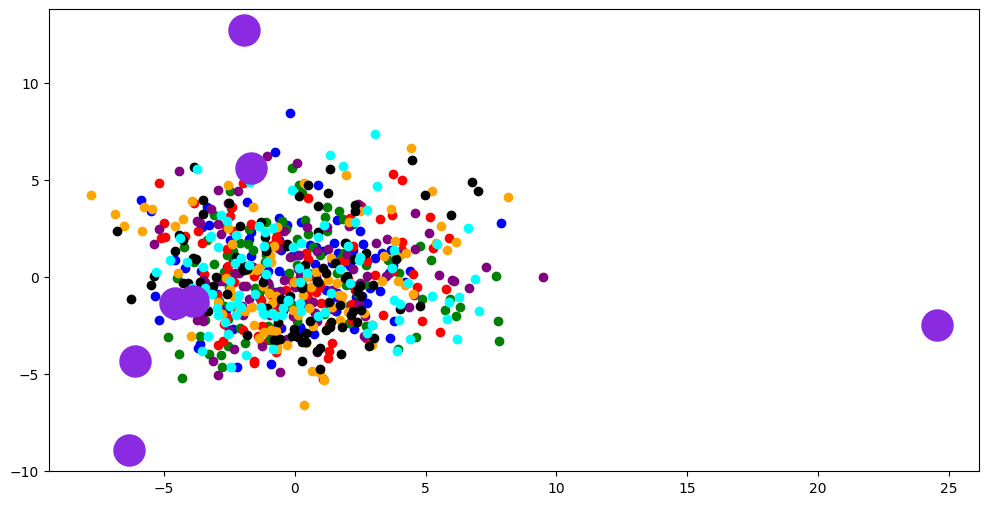

In [240]:
## GRAPHS with abstract

plt.figure(figsize=(12, 6))
draw_points(pca_vectors_for_abstracts)

#topics
plt.scatter(pca_vectors_for_topics[:, 0], pca_vectors_for_topics[:, 1], c='blueviolet', s=500)


In [161]:
def spatial_distance(vector1, vector2):
    return spatial.distance.euclidean(vector1, vector2)

# euclidean distance from one abstract to all topics, figure out what it would be categorized

def predict_correct_class(a_pca_vectors, topic_pca_vectors, correct_class):
    abstracts = []
    for i, vector in enumerate(a_pca_vectors):
        distances = []
        for topic in topic_pca_vectors:
            # euclidean distance between abstract and points
            distances.append(spatial_distance(vector,topic))
        abstracts.append(distances)
    right_wrong = [0,0]
    for distance in abstracts:
        if np.argmin(distance) == correct_class:
            right_wrong[0] += 1
        else: right_wrong[1] += 1
    return right_wrong

In [165]:
# predicted right classes for abstracts
right_wrong = []

for i, vector in enumerate(pca_vectors_for_abstracts):
    a = predict_correct_class(vector, pca_vectors_for_topics, i)
    right_wrong.append(a)
    

In [166]:
print(right_wrong)
# mk eniten oikein, sitten ct, erikoista...

[[65, 35], [31, 65], [0, 98], [3, 96], [0, 96], [0, 99], [0, 96]]


In [173]:
r = 0
w = 0
t = 0
for amounts in right_wrong:
    r += amounts[0]
    w += amounts[1]
    t += amounts[0] + amounts[1]
print("accuracy ", r/t)
print("wrongly assigned ", w/t)

accuracy  0.14473684210526316
wrongly assigned  0.8552631578947368


In [209]:
import scipy.stats as st
# get all vectors of abstracts to 1 array
a = pca_vectors_for_abstracts
a0 = a[0]
i = 1
while i < len(a):
    a0 = np.append(a0, a[i], axis=0)
    i += 1


684


In [210]:
print(X[2])
# Extract x and y
vectors = a0
x = vectors[:, 0]
y = vectors[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

[-0.90281183 -4.52115092]
-9.51153811701473 11.235123591633815 -8.107999598458967 9.960920212551443


In [211]:
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

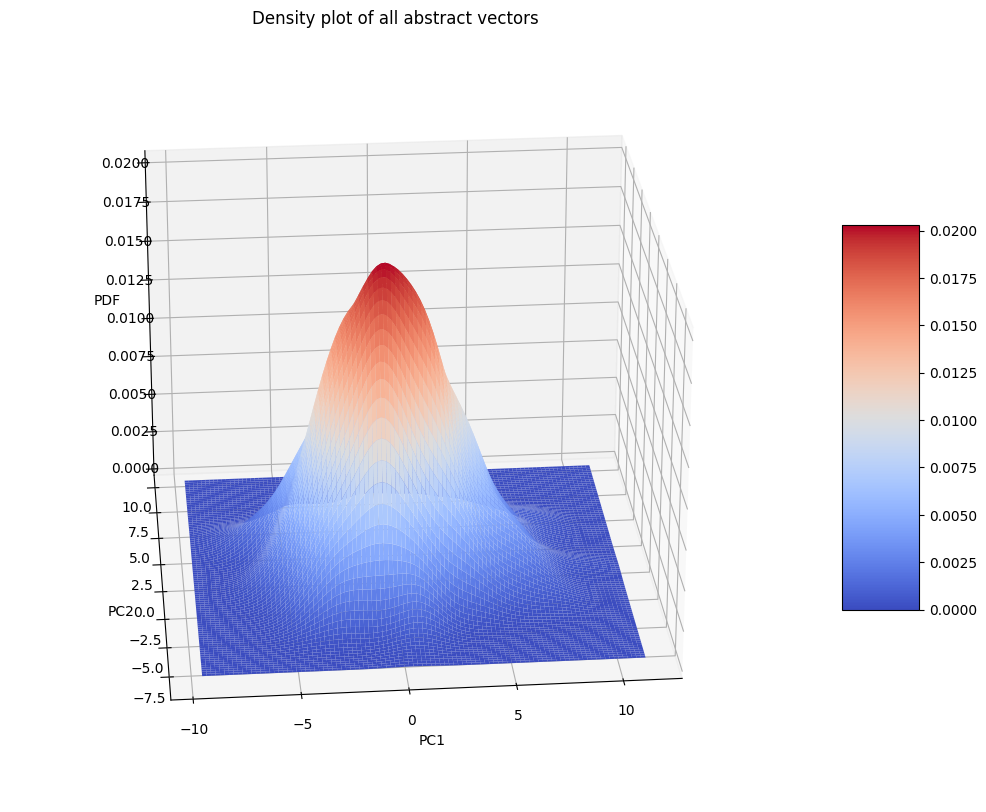

In [243]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PDF')
ax.set_title('Density plot of all abstract vectors')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(25, 85)